* To investigate the effects of bottom friction to surface flows.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## lower bottom friction
LBF_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiverLowerBF/jan2016onlyriverLBF_T.nc')
LBF_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiverLowerBF/jan2016onlyriverLBF_U.nc')
LBF_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiverLowerBF/jan2016onlyriverLBF_V.nc')

In [4]:
## higher bottom friction
HBF_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')
HBF_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_U.nc')
HBF_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_V.nc')

In [5]:
## load variables into a dict
U = {}; V={}; S={};ssh = {}
for pa,gridT,gridU,gridV in zip(['LBF','HBF'],[LBF_T,HBF_T],[LBF_U,HBF_U],[LBF_V,HBF_V]):
    U[pa] = gridU.variables['vozocrtx']
    V[pa] = gridV.variables['vomecrty']
    S[pa] = gridT.variables['vosaline']
    lon = gridT.variables['nav_lon'] 
    lat = gridT.variables['nav_lat']
    ssh[pa] = gridT.variables['sossheig']
    time_counter = gridT.variables['time_counter']

In [6]:
def plot_all(S,U,V,t,st,dep,cmin=0, cmax = 30,lonmax =-123., lonmin =-123.7, latmax =49.35, latmin = 48.9 ):  

    fig, axs = plt.subplots(1,3,figsize = (21,6))
    U_m={};V_m = {};S_m = {}
    for pa, ax in zip(['LBF','HBF'],axs[:2]):    
        S_m[pa] = S[pa][t,dep]
        S_m[pa] = np.ma.masked_array(S_m[pa],mask=np_mask[dep])
        ##unstagger u v
        Um,Vm = viz_tools.unstagger(U[pa][t,dep],V[pa][t,dep])
        #rotate
        theta = np.pi*29/180
        U_m[pa] = Um*np.cos(theta) - Vm*np.sin(theta)
        V_m[pa] = Um*np.sin(theta) +Vm*np.cos(theta)
        ##mask
        U_m[pa]=np.ma.masked_values(U_m[pa],0)
        V_m[pa]=np.ma.masked_values(V_m[pa],0)

        mesh=ax.pcolormesh(lon, lat,S_m[pa], cmap='spectral', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Practial salinity')
        quiver = ax.quiver(lon[1:,1:][::st,::st], lat[1:,1:][::st,::st], U_m[pa][::st,::st], V_m[pa][::st,::st],\
                            pivot='mid',scale=2.5,width=0.005, color='black')
        ax.quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        ax.set_title(pa)
    ##diff
    mesh=axs[2].pcolormesh(lon, lat,S_m['HBF']-S_m['LBF'],cmap='bwr', vmin=-2, vmax=2)
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Pratical salinity')
    quiver = axs[2].quiver(lon[1:,1:][::st,::st], lat[1:,1:][::st,::st],U_m['HBF'][::st,::st]-U_m['LBF'][::st,::st],\
                       V_m['HBF'][::st,::st]-V_m['LBF'][::st,::st],pivot='mid',scale=2.5,width=0.005, color='black')
    axs[2].quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black')
    viz_tools.plot_land_mask(axs[2],grid6,coords='map',color='burlywood')
    axs[2].set_title('HBF-LBF')
    for ax in axs:
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])

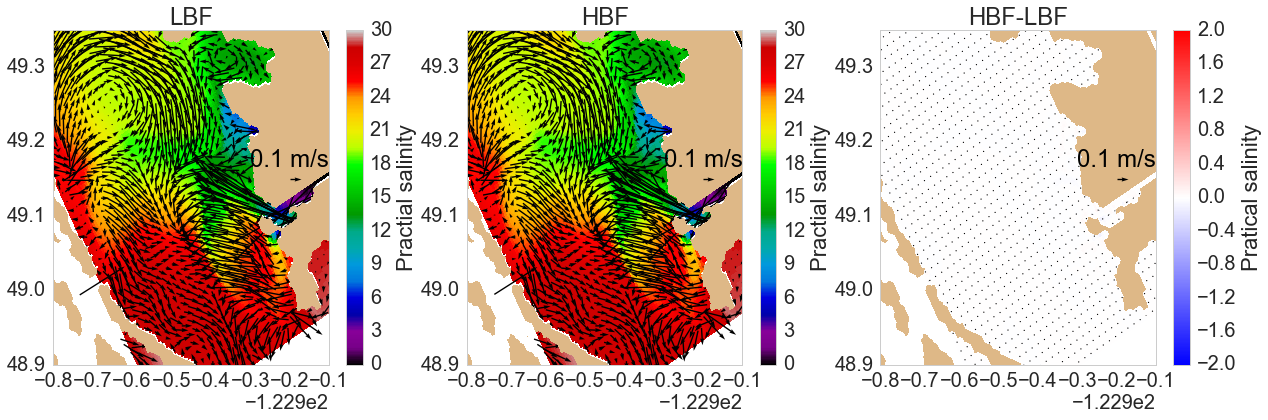

In [7]:
## START
plot_all(S,U,V,0,3,0)

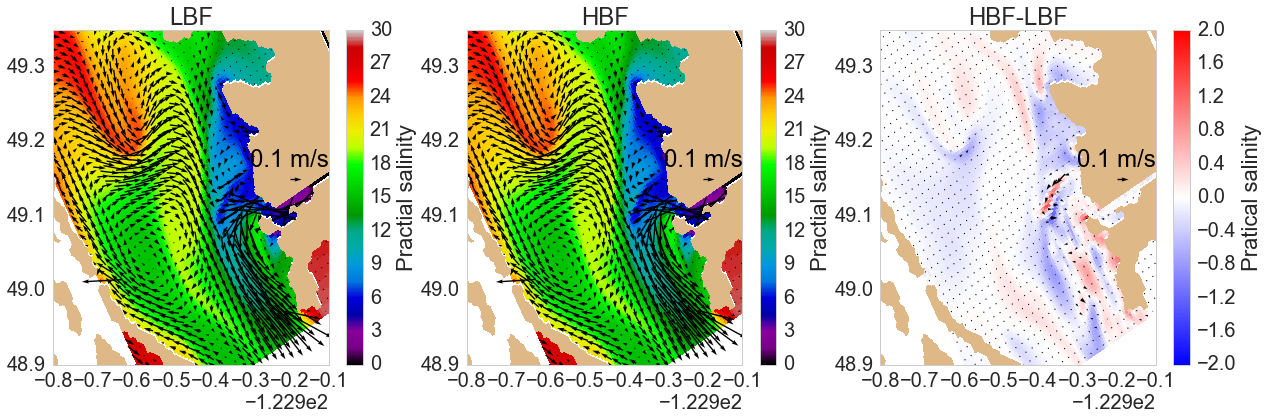

In [10]:
##  t = 100
plot_all(S,U,V,100,3,0)

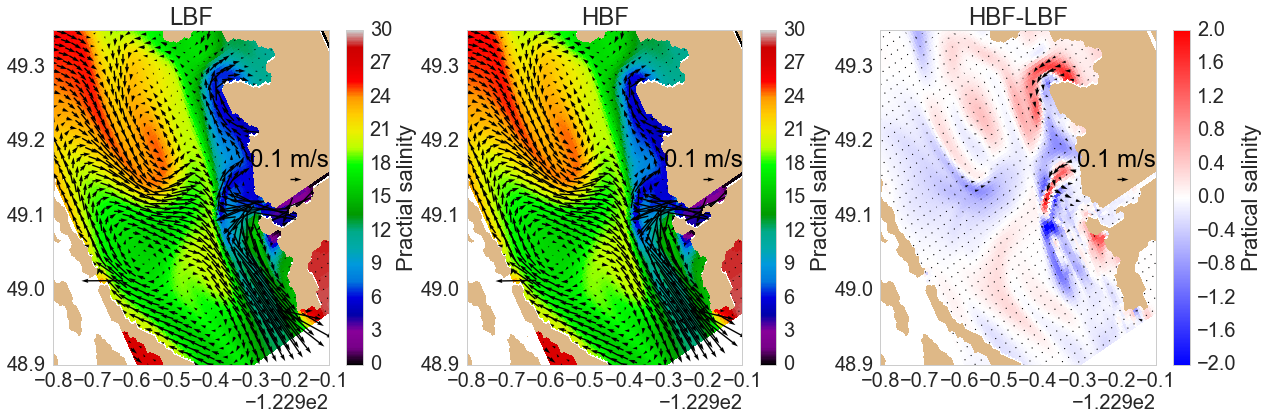

In [11]:
## t = last time
plot_all(S,U,V,119,3,0)

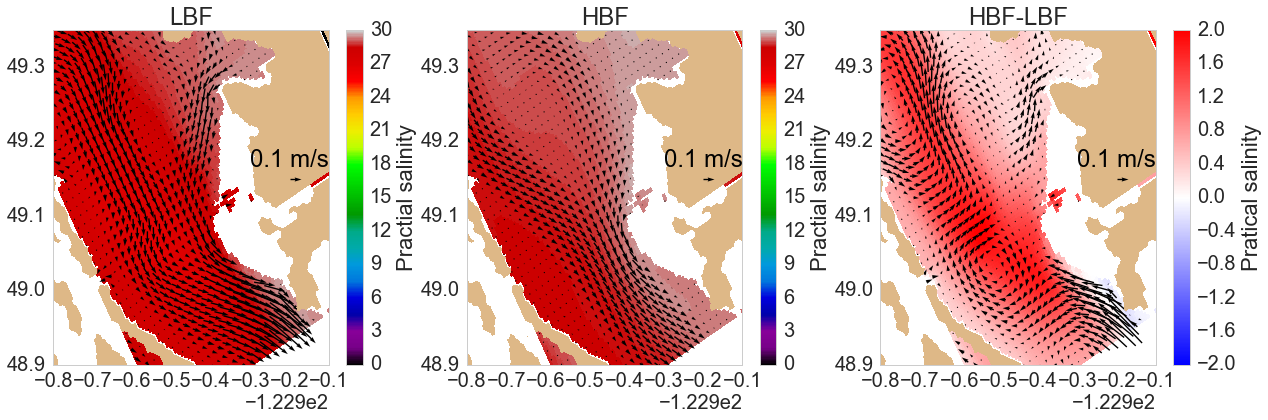

In [9]:
## t = last time at 10 m 
plot_all(S,U,V,-1,3,10)